In [ ]:
%pip install numpy
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install pandas

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F


# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

## Resizing the image

In [ ]:
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


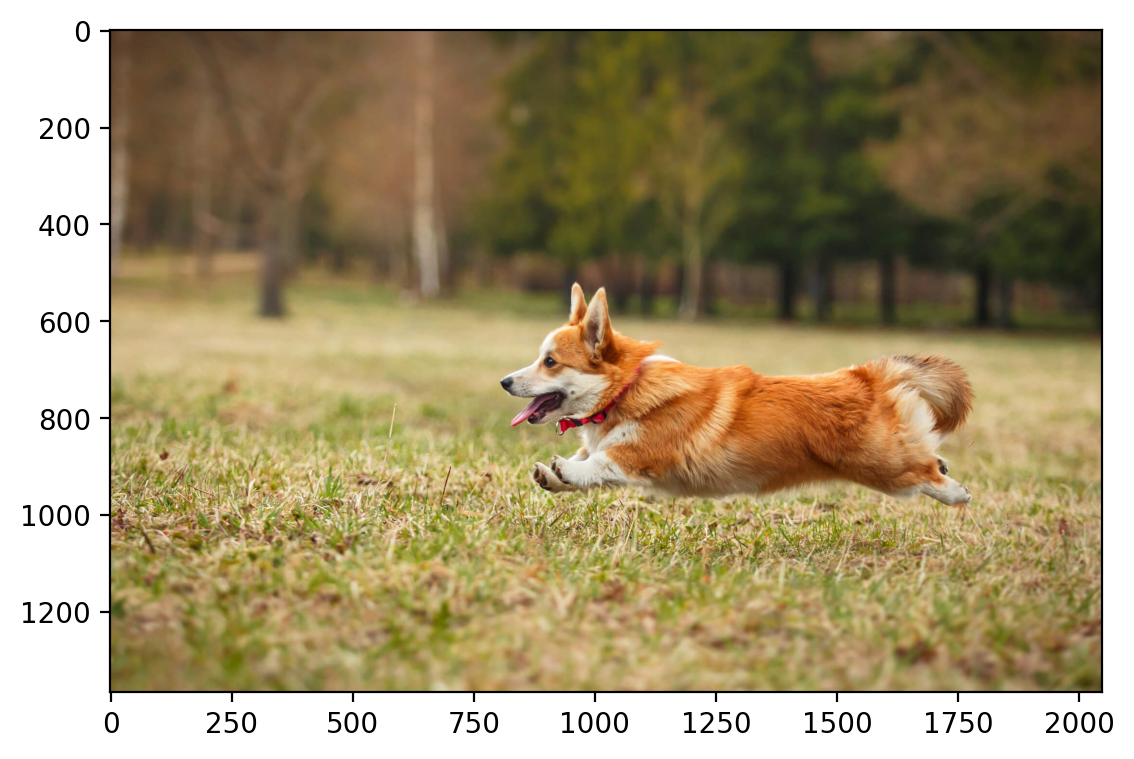

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1,1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1,1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

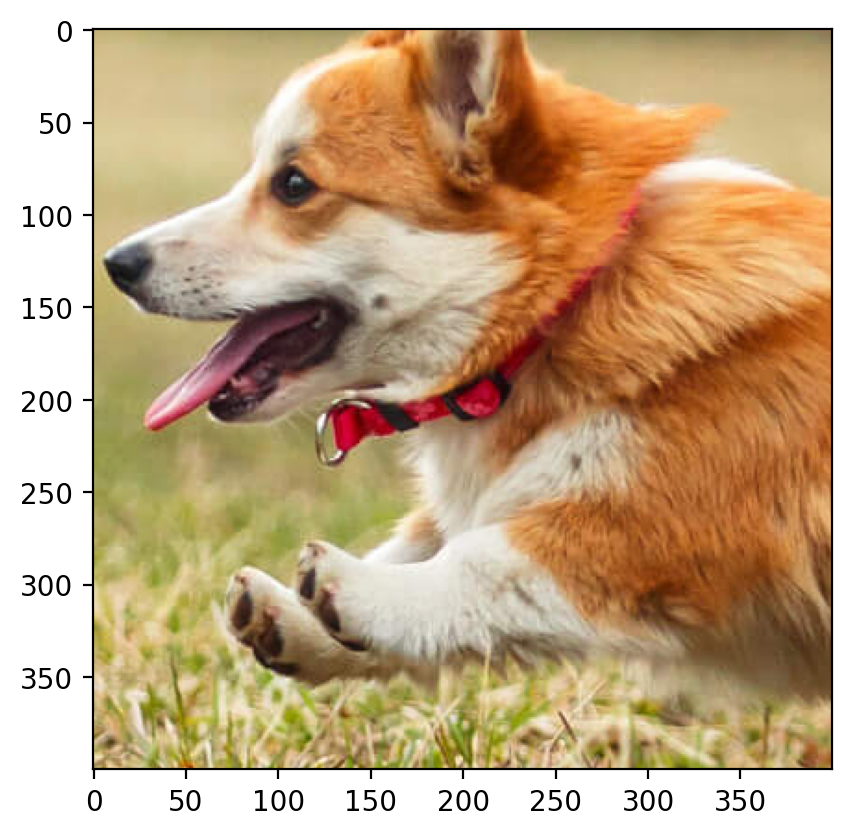

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
crop = crop.to(device)
original_img = crop
print(original_img.shape)

torch.Size([3, 400, 400])


In [ ]:
import cv2
# Permute dimensions from (C, H, W) to (H, W, C)
resized_img = cv2.resize(original_img.permute(1,2,0).numpy(), (200,200))

In [ ]:
# resized img dimension
num_channels, height, width = resized_img.shape
print(resized_img.shape)
print(type(resized_img))

(200, 200, 3)
<class 'numpy.ndarray'>


In [ ]:
resized_ = rearrange(resized_img, 'h w c -> (h w) c')
print(resized_.shape)

(40000, 3)


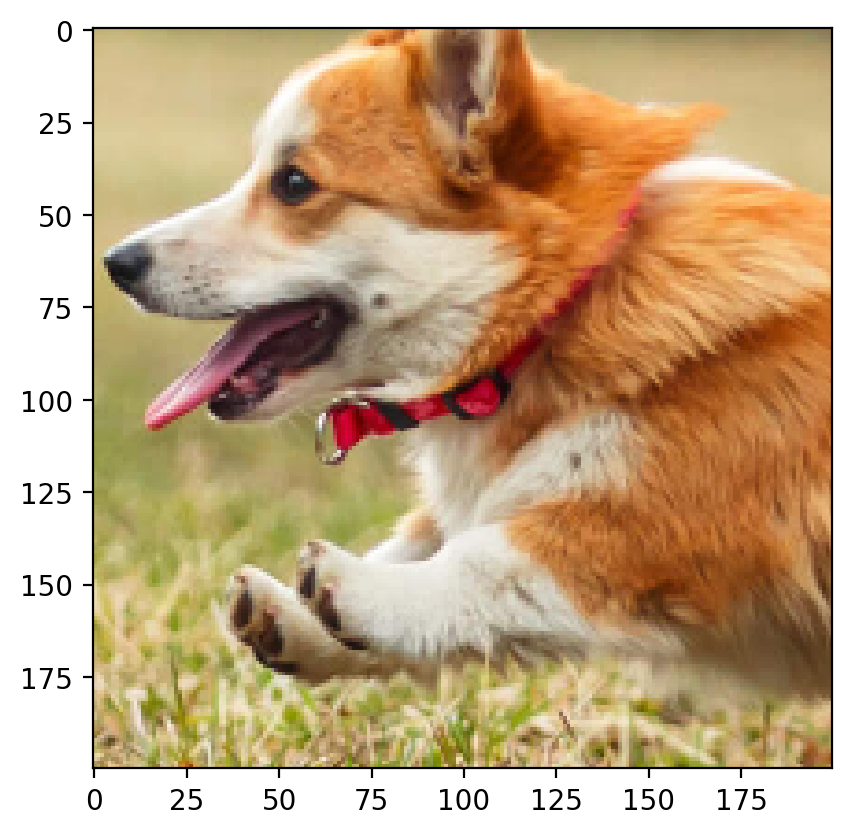

In [ ]:
plt.imshow(resized_img)

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0,width,0.5).repeat(2*height, 1)
    h_coords = torch.arange(0,height,0.5).repeat(2*width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
resized_img = rearrange(resized_img, 'h w c -> c h w')
resized_img = torch.tensor(resized_img)
resized_img = resized_img.to(device)
print(resized_img.shape)

torch.Size([3, 200, 200])


In [ ]:
dog_X, dog_Y = create_coordinate_map(resized_img)

dog_X.shape, dog_Y.shape

(torch.Size([160000, 2]), torch.Size([40000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [ ]:
def train(net, lr, X, Y, epochs, batch_size=32, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    epochs: int
    batch_size: int, default=32
    verbose: bool, default=True
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(num_batches):
            optimizer.zero_grad()
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_X = X[start_idx:end_idx]
            batch_Y = Y[start_idx:end_idx]
            outputs = net(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {running_loss / num_batches:.6f}")

In [ ]:

# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:

X_rff = create_rff_features(dog_X_scaled, 10000, 0.008)
print(X_rff.shape)
X_rff=X_rff.cpu().numpy()
X_final = np.random.random((40000, 10000))
j=0
for i in range(400):
  if i%2==0:
    X_=X_rff[i*400:i*400+400,:]
    X__=X_[::2,:]
    X_final[j*200:j*200+200,:]=X__
    j=j+1
X_rff=torch.tensor(X_rff,dtype=torch.float32).to(device)
X_final=torch.tensor(X_final,dtype=torch.float32).to(device)
net = LinearModel(X_final.shape[1], 3)
net.to(device)
# resized_.to(device)
resized_=torch.tensor(resized_,dtype=torch.float32).to(device)
train(net, 0.005, X_final,resized_, 1000,100,True)

torch.Size([160000, 10000])
Epoch 0 loss: 0.087008
Epoch 100 loss: 0.015886
Epoch 200 loss: 0.015714
Epoch 300 loss: 0.015574
Epoch 400 loss: 0.015471
Epoch 500 loss: 0.015397
Epoch 600 loss: 0.015339
Epoch 700 loss: 0.015294
Epoch 800 loss: 0.015256
Epoch 900 loss: 0.015225


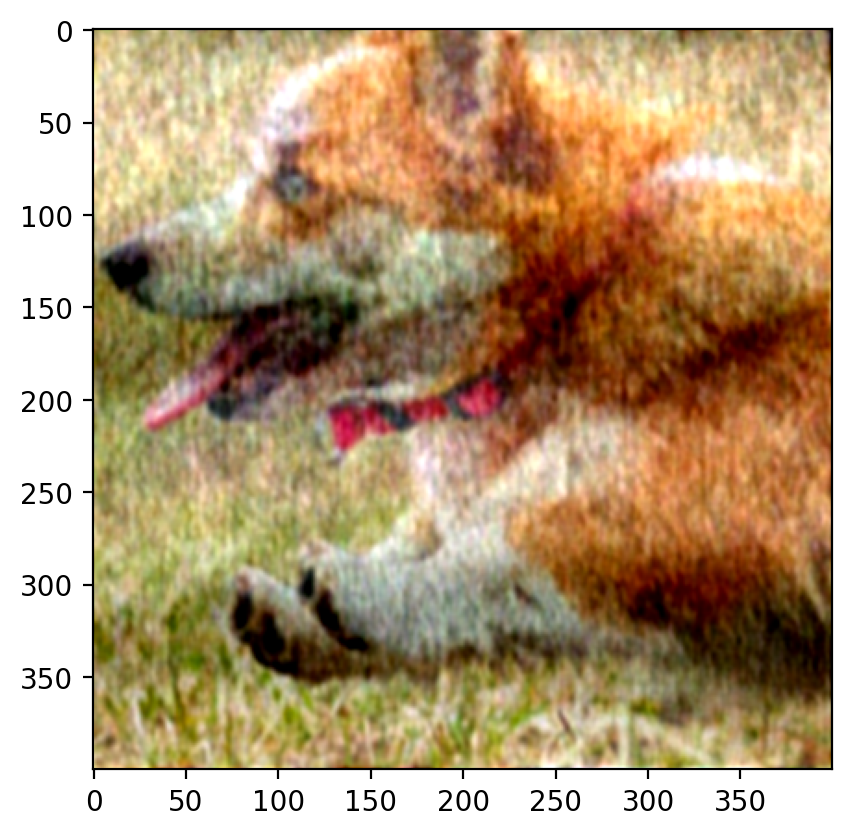

In [ ]:
with torch.no_grad():
      outputs = net(X_rff)
      outputs = outputs.reshape(400, 400, 3)
plt.imshow(outputs.cpu())

In [ ]:
def plot_reconstructed_and_original_image_RFF(original_img, net, X,maskedImage, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(400, 400, 3)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax2.set_title(f" 400*400")
    ax2.imshow(outputs.cpu())
    ax0.set_title("Original Image")
    ax0.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title(" 200*200")
    #ax1.imshow(maskedImage.reshape(200,200,3).cpu().numpy())
    ax1.imshow(rearrange(maskedImage, 'c h w -> h w c').cpu().numpy())
    squared_error = torch.square(outputs.cpu() - original_img.cpu().permute(1,2,0))
    mse = torch.mean(squared_error)


    # Calculate the root mean squared error
    rmse = torch.sqrt(mse)

    # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)

    print(f"Type: {title} , RMSE: {rmse}, PSNR: {psnr} \n")

# Calculate the PSNR
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Type: Reconstructed Image , RMSE: 0.165334812553934, PSNR: 7.816356926580703 



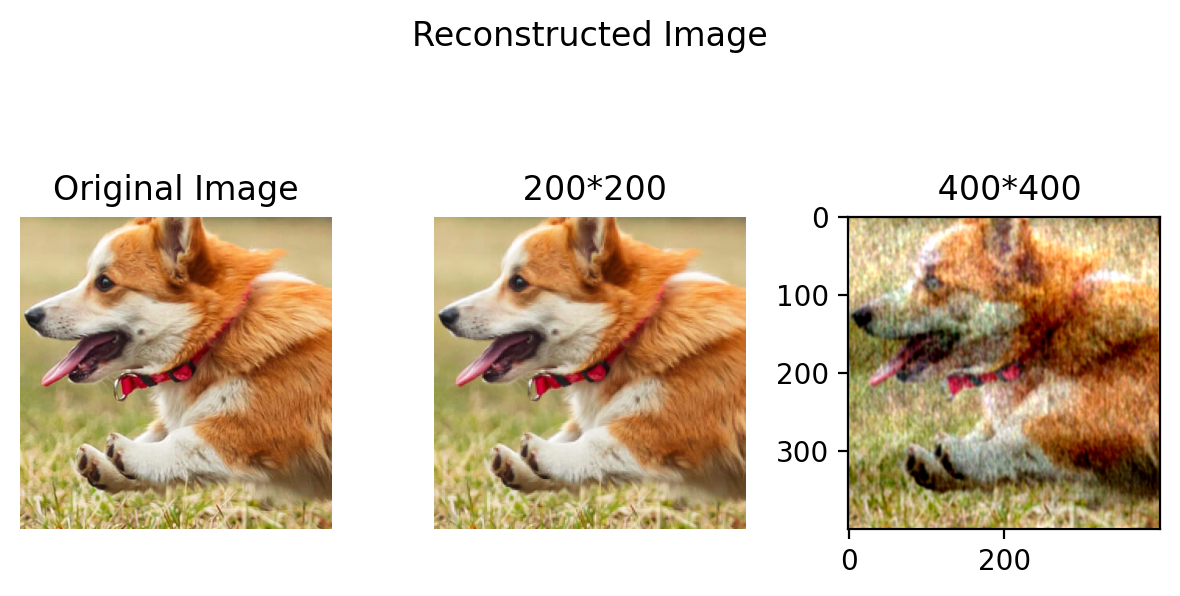

In [ ]:
plot_reconstructed_and_original_image_RFF(crop, net, X_rff, resized_img, title=f"Reconstructed Image")